## 认识数据([赛题说明](https://2019ai.futurelab.tv/contest_detail/3#contest_des))
## 了解比赛的背景
回归问题  
评分函数：
$score=1-\frac{\sum_{i=1}^{m}\left(\hat{y}_{i}-y_{i}\right)^{2}}{\sum_{i=1}^{m}\left(y_{i}-\overline{y}\right)^{2}}$

## 对比赛数据做EDA
### 数据分析


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [3]:
df = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_a.csv')

- info 方法：Print a concise summary of a DataFrame.  
    This method prints information about a DataFrame including  
    the index dtype and column dtypes, non-null values and memory usage.

In [41]:
print(df.info())

# 从pv 和 uv的条数可以发现有缺失

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 51 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

#### 缺失值分析  
(1) Take a first look at the data  

In [4]:
# 查看前5条
# print(df.head()) 

# set seed for reproducibility
np.random.seed(0) 
# 随机抽10条查看
print(df.sample(10))

              ID   area rentType houseType houseFloor  totalFloor houseToward  \
1927   100258818  79.00     未知方式    2室1厅1卫          高          13          南北   
18004  100114011  49.75     未知方式    2室1厅1卫          中           6           南   
25693  100067719  87.00     未知方式    2室1厅1卫          低          18           南   
27939  100055164  53.28     未知方式    1室1厅1卫          高           6           南   
36496  100008201  14.00       合租    3室1厅1卫          中           7           南   
14699  100146452  13.20       合租    3室1厅1卫          高           6           南   
32576  100029121  12.80       合租    4室1厅1卫          中           6           南   
16559  100124457  98.89     未知方式    2室2厅1卫          中          26           南   
20681  100096813  42.47     未知方式    1室1厅1卫          低          18           南   
30232  100042071  90.00       整租    1室2厅1卫          高          18           南   

      houseDecoration communityName city  ... landTotalPrice landMeanPrice  \
1927               其他       XQ

(2) See how many missing data points we have  

In [42]:
# 查看每个column下缺失的数量
missing_values_count = df.isnull().sum()
print(missing_values_count)

ID                     0
area                   0
rentType               0
houseType              0
houseFloor             0
totalFloor             0
houseToward            0
houseDecoration        0
communityName          0
city                   0
region                 0
plate                  0
buildYear              0
saleSecHouseNum        0
subwayStationNum       0
busStationNum          0
interSchoolNum         0
schoolNum              0
privateSchoolNum       0
hospitalNum            0
drugStoreNum           0
gymNum                 0
bankNum                0
shopNum                0
parkNum                0
mallNum                0
superMarketNum         0
totalTradeMoney        0
totalTradeArea         0
tradeMeanPrice         0
tradeSecNum            0
totalNewTradeMoney     0
totalNewTradeArea      0
tradeNewMeanPrice      0
tradeNewNum            0
remainNewNum           0
supplyNewNum           0
supplyLandNum          0
supplyLandArea         0
tradeLandNum           0


In [7]:
# how many total missing values do we have?
print(df.shape,type(df.shape))
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print('缺失率：',(total_missing/total_cells) * 100,'%')

(41440, 51) <class 'tuple'>
缺失率： 0.0017033840563252327 %


(3) 分析出现缺失值的原因  
我们需要考虑的问题之一是：**某个数据的缺失是因为它没有被记录还是根本不存在？**  
如果一个数据值缺失是因为它根本不存在，那么我们就没有必要去猜它可能的值，我们需要做的就是让它继续为 NaN；如果一个数据值缺失是因为没有被记录，我们就应该基于与它同行同列的其他值，来猜想它的可能值。 


(4) Drop missing values  
如果急于做分析，可以采取的方案之一就是剔除掉任何包含缺失值的行或列。  
但这种方法是并不推荐，要想得到更好的分析结果，还是要先合理地处理缺失值。

In [16]:
temp = df.dropna()
print(df.shape)
print(temp.shape)
missing_values_count = temp.isnull().sum()
print(missing_values_count[['pv','uv']])

(41440, 51)
(41422, 51)
pv    0
uv    0
dtype: int64


(5) Filling in missing values  
除了剔除缺失值所在的行或者列，另一个方案是去补全缺失值自动补全缺失值

In [26]:
# 先查看一下缺失值的数字类型 及 样例
print(df.dtypes[['pv','uv']])
print(df[['pv','uv']].sample(5))

pv    float64
uv    float64
dtype: object
            pv      uv
19341  64827.0  4294.0
27611  26706.0  3079.0
18699  11722.0  1570.0
11006  10489.0  1328.0
7034    3220.0   583.0


In [37]:
# 计算出缺失项的均值
mean = df[['pv','uv']].mean()

df = df.fillna(value=mean)

# fiilna填充
missing_values_count = df.isnull().sum()
print(missing_values_count)
print(df.shape)

ID                    0
area                  0
rentType              0
houseType             0
houseFloor            0
totalFloor            0
houseToward           0
houseDecoration       0
communityName         0
city                  0
region                0
plate                 0
buildYear             0
saleSecHouseNum       0
subwayStationNum      0
busStationNum         0
interSchoolNum        0
schoolNum             0
privateSchoolNum      0
hospitalNum           0
drugStoreNum          0
gymNum                0
bankNum               0
shopNum               0
parkNum               0
mallNum               0
superMarketNum        0
totalTradeMoney       0
totalTradeArea        0
tradeMeanPrice        0
tradeSecNum           0
totalNewTradeMoney    0
totalNewTradeArea     0
tradeNewMeanPrice     0
tradeNewNum           0
remainNewNum          0
supplyNewNum          0
supplyLandNum         0
supplyLandArea        0
tradeLandNum          0
tradeLandArea         0
landTotalPrice  

### 特征值分析
1. 是否有单调特征列(单调的特征列很大可能是时间)   
待补充

### 特征nunique分布
  1. 出现在测试集中的community，但是在训练集中数量较少
  

In [4]:
# 训练集中的community
print(df['communityName'].nunique())
print('-'*32)

# 测试集中的community
print(df_test['communityName'].nunique())

4236
--------------------------------
2469


2. 统计object类型的特征值出现频次大于100的特征  

In [15]:
for cols in df.columns:
    if df[cols].nunique()>100 and df[cols].dtype=='object':
        print(cols)

houseType
communityName
tradeTime


### Label分布
  1. 不同的特征值的样本的label的分布

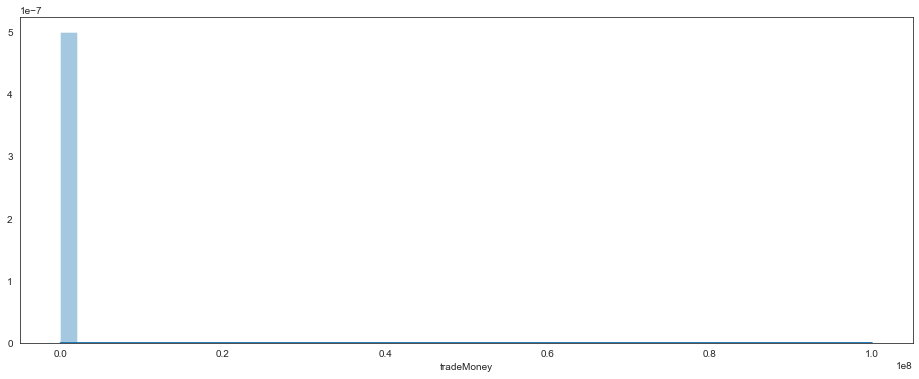

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(df['tradeMoney'])

In [19]:
# 筛选数据后再进行观察
num = len(df.index)

for i in range(1, 10):
    s = i*10000
    print('{:<6}: {:.5f}'.format(s, len(df[df['tradeMoney'] < s]) / num))

10000 : 0.93316
20000 : 0.98625
30000 : 0.99534
40000 : 0.99771
50000 : 0.99831
60000 : 0.99889
70000 : 0.99908
80000 : 0.99930
90000 : 0.99944


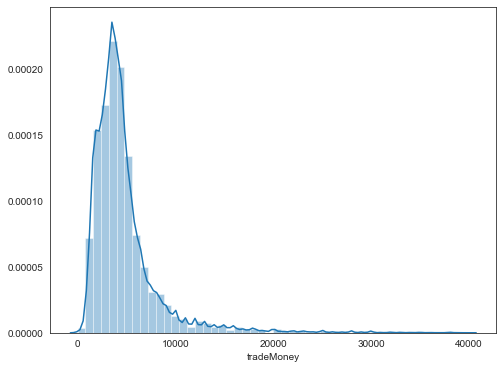

In [20]:
df = df[df['tradeMoney'] < 40000]

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['tradeMoney'])

In [49]:
? pd.DataFrame.nunique